# **Iteration 2- ALBERT** 
## MSc Project
## Surya L Ramesh (0206793)

## **Load libraries**

In [1]:

!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 35.9 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 3.3 MB 56.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [2]:
import pandas as pd
import re
import torch
# import torch_xla
# import torch_xla.core.xla_model as xm
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
# from keras.preprocessing.sequence import pad_sequences
import pickle
import os
from transformers import AlbertTokenizer
import numpy as np

import os
import pickle
import fnmatch
from termcolor import colored
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import torch
import torch.nn as nn
import random

import spacy
import shutil  # for high-level operations on files

## **Check GPU and memory availability** 
   - code is from Google Colab official examples: https://colab.research.google.com/notebooks/pro.ipynb

In [3]:
# check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug 11 19:31:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# check Memory 

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device_type = "cuda:0" if torch.cuda.is_available() else "cpu"

cuda:0


## **Mount  google drive and access datasets**

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
# Use Relative path 
#path = 'SNLI_Data_Csv'
path = "/content/drive/MyDrive/CleanedData_notEncoded"
modelPath = "/content/drive/MyDrive/CleanedData_notEncoded/model_19_07"
dirList = os.listdir(path)

In [8]:

dirList

['df_test.csv',
 'df_val.csv',
 'df_train.csv',
 'model_epoch1.pt',
 'model_epoch2.pt',
 'model_epoch3.pt',
 'model_epoch5.pt',
 'model13_07',
 'model_11_07',
 'model_19_07',
 'model_22_07_albert',
 'model_22_07_LegalBert',
 'model_22_07_Bert',
 'model_epoch4.pt',
 'df_testlegal.csv']

## **Load and view the previously cleaned dataset** 
-  after cleaning , only wanted columns are kept , remove'-' rows, from gold_label, remove rows with na , rename columns,

In [9]:
for dir in dirList:
  sub_path = os.path.join(path,dir) 
  #print(sub_path)
  if fnmatch.fnmatch(sub_path,'*df_train.csv*'):
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    train_tidy = pd.read_csv(sub_path,nrows =350000)  # changed to 10K for experimentation 
    
    
  if fnmatch.fnmatch(sub_path,'*df_val*'):  
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    val_tidy = pd.read_csv(sub_path,nrows =10000) 

  if fnmatch.fnmatch(sub_path,'*df_test.csv*'):  
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    test_tidy = pd.read_csv(sub_path,nrows =10000) 

  if fnmatch.fnmatch(sub_path,'*df_testlegal.csv*'):  
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    testlegal_tidy = pd.read_csv(sub_path,nrows =20) 





 In Filename and path: /content/drive/MyDrive/CleanedData_notEncoded/df_test.csv

 In Filename and path: /content/drive/MyDrive/CleanedData_notEncoded/df_val.csv

 In Filename and path: /content/drive/MyDrive/CleanedData_notEncoded/df_train.csv

 In Filename and path: /content/drive/MyDrive/CleanedData_notEncoded/df_testlegal.csv


In [10]:
test_tidy.head(5)

,premise,hypothesis,target
0,two men are loading bales of wheat on top of a...,it is nighttime,contradiction
1,an elderly lady holding a scruffy dog and smil...,a woman holding a scruffy cat,contradiction
2,two racers race on motorcycles,two people are racing,entailment
3,firefighters in full gear are walking up a lad...,the firefighters are trying to save a child,neutral
4,a man playing fetch with two brown dogs,the dogs are adopted,neutral


In [11]:
train_tidy.head(5)

,premise,hypothesis,target
0,a smiling boy pulls an orange object from a hat,the boy stole the hat,neutral
1,a person is riding a bike on a tree,a stunt rider is balancing a bike riding acros...,neutral
2,a bike riding is looking out into the ocean,the ocean has huge waves,neutral
3,a group of synchronized men doing aquatic exer...,a group of men wearing swim caps,neutral
4,the girl in the white strip is falling down as...,the girl in blue stripes is playing soccer,entailment


In [12]:
val_tidy.head(5)

,premise,hypothesis,target
0,a jockey in a blue helmet red shirt and white ...,there is a jockey riding a horse,entailment
1,a male with brown clothing standing on the sid...,the man is asian,neutral
2,a person in a blue shirt and tan shorts gettin...,a person is napping on the couch,contradiction
3,two men on bicycles competing in a race,a few people are catching fish,contradiction
4,a small colorful race car on the track with pe...,the car is moving very slowly,neutral


## **Define class for SNLIDataAlbert**

The class definition and training part of the code for ALBERT has been adapted from https://github.com/dh1105/Sentence-Entailment/blob/main/Sentence_Entailment_BERT.ipynb


In [13]:
''' initialising , data Loader (batches) ,encoding ,  Add [CLS] and [SEP] tokens, join the two sentences for the train and val datasets'''

class SNLIDataAlbert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'entailment': 0, 'contradiction': 1, 'neutral': 2}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'

    # second version of ALBERT is used
    
    self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512   
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['premise'].to_list()
    hypothesis_list = df['hypothesis'].to_list()
    label_list = df['target'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )
    return train_loader, val_loader

### Ensure data is of type string 

In [14]:
train_tidy['premise'] = train_tidy['premise'].astype(str)
train_tidy['hypothesis'] = train_tidy['hypothesis'].astype(str)

In [15]:
val_tidy['premise'] = val_tidy['premise'].astype(str)
val_tidy['hypothesis'] = val_tidy['hypothesis'].astype(str)

In [16]:
test_tidy['premise'] = test_tidy['premise'].astype(str)
test_tidy['hypothesis'] = test_tidy['hypothesis'].astype(str)

In [17]:
test_tidy['premise']

0       two men are loading bales of wheat on top of a...
1       an elderly lady holding a scruffy dog and smil...
2                         two racers race on motorcycles 
3       firefighters in full gear are walking up a lad...
4                a man playing fetch with two brown dogs 
                              ...                        
9819    three girls are standing and talking to each o...
9820           three women are dressed in ninja costumes 
9821      a man is standing in the doorway of a building 
9822    a younger couple is walking across a crosswalk...
9823    a woman with her face partially covered in sil...
Name: premise, Length: 9824, dtype: object

In [18]:
test_tidy['premise']

0       two men are loading bales of wheat on top of a...
1       an elderly lady holding a scruffy dog and smil...
2                         two racers race on motorcycles 
3       firefighters in full gear are walking up a lad...
4                a man playing fetch with two brown dogs 
                              ...                        
9819    three girls are standing and talking to each o...
9820           three women are dressed in ninja costumes 
9821      a man is standing in the doorway of a building 
9822    a younger couple is walking across a crosswalk...
9823    a woman with her face partially covered in sil...
Name: premise, Length: 9824, dtype: object

## **Train on trainset and validate using validation set** 

In [19]:

snli_dataset = SNLIDataAlbert(train_tidy, val_tidy)


349548
9842


In [20]:
train_loader, val_loader = snli_dataset.get_data_loaders(batch_size=16)

## **Define class for SNLIDataAlbertPredictor**

In [21]:
''' This class is for the Test set (prediction) to Initialize , data Loader (batches) ,
encoding ,  Add [CLS] and [SEP] tokens, join the two sentences '''


class SNLIDataAlbertPredictor(Dataset):

  def __init__(self,input_df):
    self.label_dict = {'entailment': 0, 'contradiction': 1, 'neutral': 2}

    self.input_df = input_df

    self.base_path = '/content/'
    # second version of ALBERT is used as earlier
    self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
    self.input_data = None
   # self.val_data = None
    self.init_data()

  def init_data(self):
    
    self.input_data = self.load_data(self.input_df)

  def load_data(self, df):
    MAX_LEN = 512   
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['premise'].to_list()
    hypothesis_list = df['hypothesis'].to_list()
    label_list = df['target'].to_list()

    for (premise, hypothesis,label) in zip(premise_list, hypothesis_list,label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids,y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    input_loader = DataLoader(
      self.input_data,
      shuffle=shuffle,
      batch_size=batch_size
    )
    return input_loader

In [22]:
# Adam optimizer and pretrained AlbertSequenceClassification

from transformers import AlbertForSequenceClassification, AdamW

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=3)
model.to(device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [23]:
# Prepare optimizer and schedule (linear warmup and decay)
# code from huggingface example - https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [24]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,685,891 trainable parameters


In [26]:
# save model 

def save_checkpoint(state, is_best, epoch ):
   path_to_model=modelPath + '/model_epoch{}.pt'.format( epoch+1)
   torch.save(state, path_to_model)
   print("The model has been saved in {}".format(path_to_model))
   if is_best:
        shutil.copyfile(path_to_model, 'model_best.pth.tar')

In [27]:
import tensorflow as tf
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [28]:
import time

EPOCHS = 10 # maximum no.of epochs to run 

def train(model, train_loader, val_loader, optimizer,epoch_to_resume):  
  total_step = len(train_loader)
  best_acc = 0
  is_best = False

  # check to resume from a previously saved epoch checkpoint

  if (epoch_to_resume> 0 ):
        path_to_model= modelPath +'/model_epoch{}.pt'.format( epoch_to_resume)
        if os.path.isfile(path_to_model):
            print("=> loading checkpoint '{}'".format(path_to_model))
            checkpoint = torch.load(path_to_model)
            savd_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_acc']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(path_to_model, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(path_to_model))

  # training and validation for each epoch

  for epoch in range(epoch_to_resume, EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0

    # for each batch 
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      
      result = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels)
      
      loss = result.loss
      prediction = result.logits

      # check if there are nan in prediction

      if(torch.any(prediction.isnan())):
        break;

      # call accuracy function 
      acc = multi_acc(prediction, labels)
   
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    # get average train accuracy and loss across all batches 
    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()#Surya find out
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        
        result = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels)
        loss = result.loss
        prediction = result.logits
        if(torch.any(prediction.isnan())):
          break;
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    if(best_acc< val_acc):
      best_acc = val_acc 
      is_best = True
    else:
      is_best = False
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    

    # Saving the model
    save_checkpoint({
            'epoch': epoch + 1,
            'best_acc': best_acc,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, is_best,epoch)
   

In [29]:
# commented out once epoch is chosen 
'''- this section is for training the model on trainset and validating on validation set-commented out'''

#%%time
#epoch_to_resume = 6
#train(model, train_loader, val_loader, optimizer,epoch_to_resume)

'- this section is for training the model on trainset and validating on validation set-commented out'

In [30]:
print('Done')

Done


In [31]:
import time

EPOCHS = 6 # maximum no.of epochs to run 

def test(model, test_loader, optimizer,epoch_to_use):  
  # check to resume from a previously saved epoch checkpoint
  if (epoch_to_use > 0 ):
        path_to_model= modelPath +'/model_epoch{}.pt'.format( epoch_to_resume)
        if os.path.isfile(path_to_model):
            print("=> loading checkpoint '{}'".format(path_to_model))
            checkpoint = torch.load(path_to_model)
            savd_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_acc']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(path_to_model, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(path_to_model))
            return; 
  y_pred_all = np.array([])
  y_test_all = np.array([])
  start = time.time() 
  total_test_loss = 0
  total_test_acc  = 0

  for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(test_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      
      result = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            labels=labels)
      loss = result.loss
      prediction = result.logits
      if(torch.any(prediction.isnan())):
        break;
      
      acc = multi_acc(prediction, labels)
      #Add all predictions to y_pred_arr and all lables to y_test_arr
      y_pred = torch.log_softmax(prediction, dim=1).argmax(dim=1)
      y_pred_arr =  y_pred.to("cpu").numpy().squeeze() 
      y_test_arr = labels.to("cpu").numpy().squeeze()
      y_pred_all = np.append(y_pred_all,y_pred_arr, axis=0)
      y_test_all = np.append(y_test_all,y_test_arr, axis=0)      
      total_test_loss += loss.item()
      total_test_acc  += acc.item()

      test_acc  = total_test_acc/len(test_loader)
      test_loss = total_test_loss/len(test_loader)
      end = time.time()
      hours, rem = divmod(end-start, 3600)
      minutes, seconds = divmod(rem, 60)

  print(f'With Epoch {epoch_to_use}: test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  return y_pred_all,y_test_all 



In [32]:
#Create object of SNLIAlberPredictor
#GEt test dataloader
snli_testset = SNLIDataAlbertPredictor(test_tidy)
test_loader = snli_testset.get_data_loaders(batch_size=16)

9824


In [33]:
test_tidy

,premise,hypothesis,target
0,two men are loading bales of wheat on top of a...,it is nighttime,contradiction
1,an elderly lady holding a scruffy dog and smil...,a woman holding a scruffy cat,contradiction
2,two racers race on motorcycles,two people are racing,entailment
3,firefighters in full gear are walking up a lad...,the firefighters are trying to save a child,neutral
4,a man playing fetch with two brown dogs,the dogs are adopted,neutral
...,...,...,...
9819,three girls are standing and talking to each o...,three girls are seated,contradiction
9820,three women are dressed in ninja costumes,there are multiple people present,entailment
9821,a man is standing in the doorway of a building,the man is walking into a room,neutral
9822,a younger couple is walking across a crosswalk...,the couple are walking away from the wrong bus...,neutral


In [34]:
#epoch_to_use = 6
epoch_to_resume = 6
y_pred_all,y_test_all = test(model, test_loader, optimizer,epoch_to_resume)

=> loading checkpoint '/content/drive/MyDrive/CleanedData_notEncoded/model_19_07/model_epoch6.pt'
=> loaded checkpoint '/content/drive/MyDrive/CleanedData_notEncoded/model_19_07/model_epoch6.pt' (epoch 6)
With Epoch 6: test_loss: 0.3892 test_acc: 0.8598
00:00:29.09


## **Predict on Testset and Visualize**

In [35]:
# Libraries for this section 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

In [36]:
''' function for custom confusion matrix in colour  '''

def plot_confusion_matrix_custom(cm, classes, title='Confusion matrix - ALBERT', cmap=plt.cm.Blues):
  
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False) 
   
    plt.show()

In [37]:
''' function written to print classification report and display custom confusion matrix'''



def visualize_confusion_matrix(y_pred_argmax, y_true):

    classes = ['entailment','contradiction','neutral']
    cm = confusion_matrix(y_true, y_pred_argmax)
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true,target_names=classes))

    plot_confusion_matrix_custom(cm,classes)


In [38]:
print(y_pred_all)
print(y_test_all)

[2. 1. 0. ... 1. 1. 2.]
[2. 1. 0. ... 1. 1. 2.]


               precision    recall  f1-score   support

   entailment       0.88      0.88      0.88      3337
contradiction       0.91      0.86      0.88      3405
      neutral       0.80      0.83      0.81      3082

     accuracy                           0.86      9824
    macro avg       0.86      0.86      0.86      9824
 weighted avg       0.86      0.86      0.86      9824



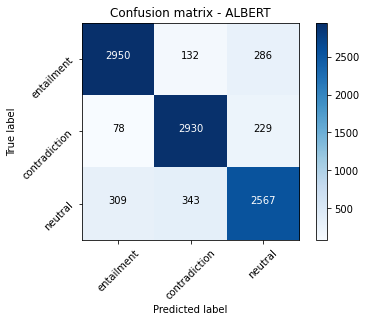

In [39]:
#classification report and Confusion matrix 
visualize_confusion_matrix(y_pred_all,y_test_all)

## ---------------------------------------------- **End of code for ALBERT** ------------------------------------------------------------------------

## **This section is for checking individual sentence-pair inputs from user**

In [40]:
def check_similarity(sentence1, sentence2):
           
       data_input = {'premise':[sentence1], 'hypothesis':[sentence2]}
       df_input = pd.DataFrame(data_input, columns = ['premise','hypothesis'])
       
       input_dataset = SNLIDataAlbertPredictor(df_input)
       input_loader = input_dataset.get_data_loaders(batch_size=1)
       
       (pair_token_ids, mask_ids, seg_ids) = next(iter(input_loader))
       pair_token_ids = pair_token_ids.to(device)
       mask_ids = mask_ids.to(device)
       seg_ids = seg_ids.to(device)
       result = model(pair_token_ids, 
                                     token_type_ids=seg_ids, 
                                     attention_mask=mask_ids)
       prediction = result.logits #Predition in tensor Form
       softmax =torch.log_softmax(prediction, dim=1)
       pred =softmax.argmax(dim=1)
       #target_map = {0: 'contradiction',1:'entailment',2:'neutral'}# error 
       target_map = {0: 'entailment',1:'contradiction',2:'neutral'}
       #target_map = {0:'entailment': 0, 'contradiction': 1, 'neutral': 2}
       
       if device_type == "cpu":
          outcome = target_map[pred.data.cpu().numpy()[0]]
       else:
           outcome = target_map[pred[0]]  
       return  outcome # modified to get value from tensor

In [41]:
sentence1 ='This church choir sings to the masses as they sing joyous songs from the book at a church.'
sentence2 ='A choir singing at a baseball game.'
data_input = {'premise':[sentence1], 'hypothesis':[sentence2],'target':['entailment']}  #### 
df_input = pd.DataFrame(data_input, columns = ['premise','hypothesis','target'])

df_input.head()

,premise,hypothesis,target
0,This church choir sings to the masses as they ...,A choir singing at a baseball game.,entailment


In [42]:
input_dataset = SNLIDataAlbertPredictor(df_input)
input_loader = input_dataset.get_data_loaders(batch_size=1)
#label_dict = {'entailment': 0, 'contradiction': 1, 'neutral': 2}

1


## Testing with Legal based sentences provided by company

In [43]:
# function to load data and tidy it 
# pass the dataframe, kepp only unwanted columns, remove'-' rows, from gold_label, remove rows with na , rename columns,lower case, replace all given special characters
# diplay head()

def data_load_tidy(dataframe): # remove isTest- not needed???
    
    dataframe = dataframe[['sentence1','sentence2','gold_label']]
    
    dataframe = dataframe[dataframe['gold_label'] != '-' ]
    dataframe= dataframe.dropna(axis=0, inplace=False) # fixed additional nan in test and val with inplace=False 
    data_tidy = dataframe.rename(columns= {'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'target'}, inplace=False)
    #data_tidy['premise'] = data_tidy['premise'].astype(str)
  
    data_tidy['premise'] = data_tidy.premise.str.lower().str.replace('[^a-zA-Z ]' , '')  
    data_tidy['hypothesis'] = data_tidy.hypothesis.str.lower().str.replace('[^a-zA-Z ]' , '')    # lower, replace all  given special characters
  
    print(colored('\n  data is tidied ....','green')) 
    return data_tidy

    

In [44]:
for dir in dirList:
  sub_path = os.path.join(path,dir) 
 
  if fnmatch.fnmatch(sub_path,'*df_testlegal.csv*'):  
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    df_legaltest = pd.read_csv(sub_path,nrows =20) 
    legaltest_tidy = data_load_tidy(df_legaltest)


 In Filename and path: /content/drive/MyDrive/CleanedData_notEncoded/df_testlegal.csv

  data is tidied ....


In [45]:
df_legaltest.head(5)

,sentence1,sentence2,gold_label
0,It is necessary for a skilled person in the ar...,A patent has to be understood by an ordinary s...,contradiction
1,The custody order has to be executed by the Se...,The Secretary of State has to consider an inte...,entailment
2,The guidance that the Secretary of State gives...,Secretary of State`s guidance cannot be for an...,entailment
3,The question does not arise on the present case.,The court can confiscate property under any ci...,neutral
4,A rule in article 4 determines the law of the ...,There is a correct approach to determine the l...,entailment


In [46]:
legaltest_tidy.head(3)

,premise,hypothesis,target
0,it is necessary for a skilled person in the ar...,a patent has to be understood by an ordinary s...,contradiction
1,the custody order has to be executed by the se...,the secretary of state has to consider an inte...,entailment
2,the guidance that the secretary of state gives...,secretary of states guidance cannot be for an ...,entailment


In [47]:
legaltest_tidy.shape[0]

19

In [48]:
#legalset = legaltest_tidy[['premise','hypothesis','target']]

In [49]:
#Create object of SNLIAlberPredictor
#get legaltest set
snli_legaltestset = SNLIDataAlbertPredictor(legaltest_tidy)
legaltest_loader = snli_legaltestset.get_data_loaders(batch_size=16)

19


In [57]:
# for ALBERT - testing on small Legalset
epoch_to_resume = 6
y_pred_legalall,y_test_legalall = test(model, legaltest_loader, optimizer,epoch_to_resume)

=> loading checkpoint '/content/drive/MyDrive/CleanedData_notEncoded/model_19_07/model_epoch6.pt'
=> loaded checkpoint '/content/drive/MyDrive/CleanedData_notEncoded/model_19_07/model_epoch6.pt' (epoch 6)
With Epoch 6: test_loss: 1.3764 test_acc: 0.3854
00:00:00.04


## Download colab notebook as HTML

In [58]:
## download as html
%%shell
jupyter nbconvert --to html /content/Iteration2_ALBERT.ipynb



[NbConvertApp] Converting notebook /content/Iteration2_ALBERT.ipynb to html
[NbConvertApp] Writing 477267 bytes to /content/Iteration2_ALBERT.html
